Competition URL:

https://datahack.analyticsvidhya.com/contest/build-a-recommendation-engine-powered-by-ibm-cloud/


test.csv: Contains first 50% transactions for a different set of customers for whom recommendations are to be made. 



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

In [5]:
train_data = pd.read_csv("train.csv")

## Exploring train data 

In [3]:
train_data.shape

(330575, 7)

In [6]:
train_data.head()

,CustomerID,InvoiceNo,Quantity,InvoiceDate,UnitPrice,Country,StockCode
0,27270,27270,7,01/12/10 8:26,2.55,PX,85123AY
1,27270,27270,7,01/12/10 8:26,3.39,PX,71053R
2,27270,27270,9,01/12/10 8:26,2.75,PX,84406BH
3,27270,27270,7,01/12/10 8:26,3.39,PX,84029GV
4,27270,27270,7,01/12/10 8:26,3.39,PX,84029EX


In [17]:
train_data[["Country", "StockCode"]].describe()

,Country,StockCode
count,330575,330575
unique,38,3810
top,PX,85123AY
freq,302992,1399


In [18]:
len(train_data["CustomerID"].unique()), len(train_data["InvoiceNo"].unique())

(972, 972)

In [10]:
len(train_data[train_data["CustomerID"]!=train_data["InvoiceNo"]])

0

In [21]:
%%time
train_data["InvoiceDate"] = pd.to_datetime(train_data["InvoiceDate"])

Wall time: 1min 11s


In [48]:
train_data["InvoiceDate"].describe()

count                  330575
unique                  13954
top       2011-10-31 14:41:00
freq                     1112
first     2010-01-12 08:26:00
last      2011-12-10 17:19:00
Name: InvoiceDate, dtype: object

In [49]:
train_data.groupby("CustomerID")["InvoiceDate"].size().sort_values(ascending=False).head()

CustomerID
11790     1996
129969    1649
317277    1643
198198    1610
220878    1553
Name: InvoiceDate, dtype: int64

In [99]:
customer_visits = train_data[["CustomerID", "InvoiceDate"]].drop_duplicates().groupby("CustomerID")["InvoiceDate"].size()
np.percentile(customer_visits.values,[0,5, 10,25,50,75,90,95,99,100])

array([ 1.  ,  1.  ,  2.  ,  5.  , 11.  , 23.  , 35.  , 42.  , 49.29,
       54.  ])

In [61]:
train_basket_sizes = train_data.groupby(["CustomerID", "InvoiceDate"])["StockCode"].size()
np.percentile(train_basket_sizes, [0,5, 10,25,50,75,90,95,99,100])

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 1.1000e+01,
       2.5000e+01, 4.9000e+01, 7.2000e+01, 1.9614e+02, 1.1120e+03])

### Train dataset observations:

All cases, customerID and invoce no are same. So only one of these can be considered
* Total 972 Customers present in train dataset
* Corresponding to 38 countries, and 3810 stockcodes
* Invoices correspond to period from 2010 Jan 12 to 2011 Dec 10th; 
* A few users (5%) have single trip, for which predictions might be tougher. 90 % users have atleast 2 trips, with top 10% users having nearly 35 trips.
* A typical basket size is small with 25% baskets having 3 or fewer items, and median only 10 items. Only the top 10 percent Sessions have baskets of 50 or more items

Futher questions:
1. If an item is purchased by a user, how likely is it purchased again?
2. Are some items purchased more often than others?
3. Are there groups of items that if one is purchased, others are likely to be purchased?

Seems to be a combination of Time-Series + Market-Basket + Recommendation problem

Let's also Explore how much of the data is contained in test dataset

In [37]:
test_data = pd.read_csv("test.csv")

In [46]:
%%time
test_data["InvoiceDate"] = pd.to_datetime(test_data["InvoiceDate"])

Wall time: 22 s


In [41]:
len([cust_id for cust_id in train_data["CustomerID"].unique() if cust_id in test_data["CustomerID"].unique()])

0

In [43]:
train_stocks = train_data["StockCode"].unique()
test_stocks = test_data["StockCode"].unique()

In [64]:
test_data[["StockCode", "InvoiceDate", "Country"]].describe()

,StockCode,InvoiceDate,Country
count,103097,103097,103097
unique,3522,7820,32
top,85123AY,2010-09-12 14:09:00,PX
freq,455,323,94356
first,NaN,2010-01-12 08:28:00,NaN
last,NaN,2011-12-10 16:36:00,NaN


In [45]:
len(test_stocks), len([st_ for st_ in test_stocks if st_ not in train_stocks])

(3522, 50)

In [101]:
test_customer_visits = test_data[["CustomerID", "InvoiceDate"]].drop_duplicates().groupby("CustomerID")["InvoiceDate"].size()
np.percentile(test_customer_visits.values,[0,5, 10,25,50,75,90,95,99,100])

array([ 1.  ,  1.  ,  2.  ,  4.  , 10.  , 19.  , 29.  , 33.  , 42.73,
       50.  ])

In [62]:
test_basket_sizes = test_data.groupby(["CustomerID", "InvoiceDate"])["StockCode"].size()
np.percentile(test_basket_sizes, [0,5, 10,25,50,75,90,95,99,100])

array([  1.  ,   1.  ,   1.  ,   3.  ,   7.  ,  14.  ,  26.  ,  38.  ,
       107.26, 323.  ])

C:\Users\dilee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


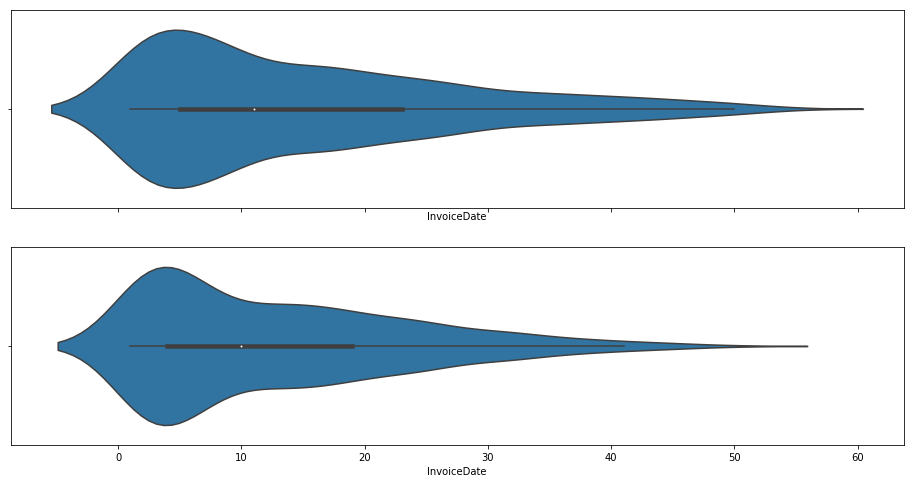

In [102]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
sns.violinplot(customer_visits ,ax = axes[0])
sns.violinplot(test_customer_visits, ax=axes[1])

Text(0.5, 1.0, 'Test Basket Size')

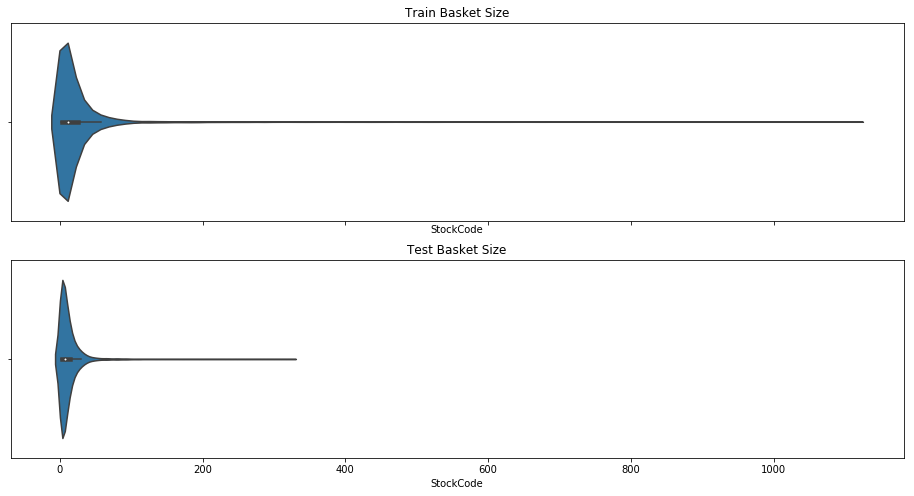

In [103]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
sns.violinplot(train_basket_sizes ,ax = axes[0])
axes[0].set_title("Train Basket Size")
sns.violinplot(test_basket_sizes, ax=axes[1])
axes[1].set_title("Test Basket Size")

### Test dataset observations:

* Basket size within one session  seem to be around half in test data, compared to in train data. Meaning, first 50% transactions of a given basket are present in test data?
* DateRange, TopCountry, TopStocks are all the same in test dataset compared to in train dataset
* Majority of stocks of test are present in train dataest as well. Only around 1% are new. 
* The customers are completely new. 


In [65]:
sample_submission = pd.read_csv("sample_submission.csv")

#### Sample Submission 1

For every user, get all items they purchased, and recommend same items. 

In [88]:
sample1 = test_data[["CustomerID", "StockCode"]].drop_duplicates().groupby("CustomerID")["StockCode"].apply(list)

sample1 = pd.DataFrame(sample1).reset_index()
sample1.columns = ["CustomerID", "Items"]

sample1.to_csv("plain_historical_submission.csv", index=False)

This approach had a score of 0; 

### Explore baskets in train data

Are there some items that are more purchased than others?
* For a given stockcode, no:of times it is bought by a given customer who bought it/no:of store visits of that customer

In [104]:
customer_visits[27270]

31

In [105]:
train_stock_repurchases = train_data.groupby(["CustomerID", "StockCode"]).size()

In [108]:
train_stock_repurchases.head()

CustomerID  StockCode
0           15056BLH     1
            15056ND      1
            15058CH      1
            15060BB      1
            16218Y       1
dtype: int64

In [124]:
def get_stock_ratios(trips_count, stock_repurchases):
    trips_df = pd.DataFrame(trips_count).reset_index()
    stocks_df = pd.DataFrame(stock_repurchases).reset_index()
    merge_df = pd.merge(trips_df, stocks_df, on="CustomerID")
    merge_df = merge_df.rename(columns={"InvoiceDate":"Trips", 0:"stock_purchases"})
    return merge_df

In [125]:
train_stocks_summary = get_stock_ratios(customer_visits, train_stock_repurchases)

In [126]:
train_stocks_summary.head()

,CustomerID,Trips,StockCode,stock_purchases
0,0,20,15056BLH,1
1,0,20,15056ND,1
2,0,20,15058CH,1
3,0,20,15060BB,1
4,0,20,16218Y,1


In [127]:
train_stocks_summary[train_stocks_summary["Trips"]==1].shape

(1078, 4)

In [128]:
train_stocks_summary.shape

(271031, 4)

In [133]:
# Considering only those customers with atleast 2 trips, look at the avg no:of stock purchases for a given stock
stocks_aggregate = train_stocks_summary[train_stocks_summary["Trips"]>1].groupby("StockCode")["stock_purchases"].agg(["mean", "max"])

In [135]:
stocks_aggregate.shape

(3809, 2)

In [136]:
len(stocks_aggregate[stocks_aggregate["max"]==1]), len(stocks_aggregate[stocks_aggregate["max"]>1])

(1314, 2495)

1/3rd items are purchased only once. 2/3rd items are purchased multiple times. But these too are not purchased 

In [121]:
train_stocks_summary.head()

,CustomerID,InvoiceDate,StockCode,0
0,0,20,15056BLH,1
1,0,20,15056ND,1
2,0,20,15058CH,1
3,0,20,15060BB,1
4,0,20,16218Y,1


In [107]:
train_stock_repurchases[27270].head()

StockCode
15036Z     1
16156SH    1
16161PA    1
20713F     1
20724F     1
dtype: int64

In [91]:
train_data.head()

,CustomerID,InvoiceNo,Quantity,InvoiceDate,UnitPrice,Country,StockCode
0,27270,27270,7,2010-01-12 08:26:00,2.55,PX,85123AY
1,27270,27270,7,2010-01-12 08:26:00,3.39,PX,71053R
2,27270,27270,9,2010-01-12 08:26:00,2.75,PX,84406BH
3,27270,27270,7,2010-01-12 08:26:00,3.39,PX,84029GV
4,27270,27270,7,2010-01-12 08:26:00,3.39,PX,84029EX


In [96]:
train_data[train_data["CustomerID"]==27270]

,CustomerID,InvoiceNo,Quantity,InvoiceDate,UnitPrice,Country,StockCode
0,27270,27270,7,2010-01-12 08:26:00,2.55,PX,85123AY
1,27270,27270,7,2010-01-12 08:26:00,3.39,PX,71053R
2,27270,27270,9,2010-01-12 08:26:00,2.75,PX,84406BH
3,27270,27270,7,2010-01-12 08:26:00,3.39,PX,84029GV
4,27270,27270,7,2010-01-12 08:26:00,3.39,PX,84029EX
5,27270,27270,2,2010-01-12 08:26:00,7.65,PX,22752G
6,27270,27270,7,2010-01-12 08:26:00,4.25,PX,21730R
9089,27270,27270,14,2010-07-12 10:32:00,1.45,PX,22147L
9090,27270,27270,14,2010-07-12 10:32:00,2.10,PX,84375E
9091,27270,27270,14,2010-07-12 10:32:00,1.65,PX,84050K


In [93]:
train_basket_sizes[27270]

InvoiceDate
2010-01-12 08:26:00     7
2010-07-12 10:32:00    22
2010-12-13 11:11:00     1
2010-12-21 10:35:00     1
2011-01-17 16:20:00     3
2011-02-06 09:38:00     1
2011-02-09 12:01:00    20
2011-02-12 16:04:00     7
2011-03-18 08:31:00    19
2011-04-17 13:04:00    18
2011-04-28 14:36:00     1
2011-05-08 14:50:00    14
2011-05-10 15:35:00    45
2011-05-18 10:50:00     4
2011-06-15 14:23:00     1
2011-06-20 14:38:00     6
2011-07-03 12:26:00    11
2011-07-09 11:32:00    30
2011-07-11 08:26:00    14
2011-08-12 18:25:00    11
2011-08-23 16:49:00    13
2011-08-28 13:35:00    50
2011-09-05 16:41:00     1
2011-09-15 15:35:00     5
2011-09-28 11:11:00     1
2011-10-17 13:44:00    21
2011-10-24 16:48:00     4
2011-11-07 15:22:00     4
2011-11-11 12:07:00    13
2011-12-08 09:04:00    17
2011-12-09 12:48:00    12
Name: StockCode, dtype: int64